In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from __future__ import division

import copy
import os
import argparse
import numpy as np

# Astropy related
from astropy.io import fits
from astropy.table import Table

# Matplotlib default settings
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 12, 10
mpl.rcParams['xtick.major.size'] = 8.0
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 8.0
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4.0
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rc('axes', linewidth=2)

# Shapely related imports
from shapely.geometry import Polygon, LineString, Point
from shapely          import wkb
from shapely.ops      import cascaded_union

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Read a .wkb file into a Polygon shape

def polyReadWkb(wkbName, load=True):

    wkbFile = open(wkbName, 'r')
    polyWkb = wkbFile.read().decode('hex')
    wkbFile.close()

    if load is True:
        return wkb.loads(polyWkb)
    else:
        return polyWkb

In [65]:
# Polygon that defines the region that is covered by Data for certain Tract 
acpMask = 'ssp385_wide_hec_tract_all.wkb'
# Polygons that define the regions have NO_DATA mask for certain Tract
rejMask = 'ssp385_wide_hec_nodata_big.wkb'

In [66]:
acpRegs = polyReadWkb(acpMask)
rejRegs = polyReadWkb(rejMask)

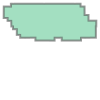

In [67]:
acpRegs

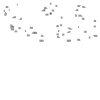

In [68]:
rejRegs

In [70]:
# Input catalog that contains (RA, DEC)
#inCat  = '../hsc_gama_g15_sdss'
#outCat = inCat + '_match'
inCat = '../redmapper_dr8_public_v5.10_catalog_flat.fits'
outCat = 'hsc_redmapper_hec.fits'

# Read in the input catalog 
#catData = Table.read(inCat + '.fits', format='fits')
catData = Table.read(inCat, format='fits')

#ra  = 'ra_gama'  
#dec = 'dec_gama' 
#ra  = 'ra_pho'
#dec = 'dec_pho'
ra  = 'RA'
dec = 'DEC'

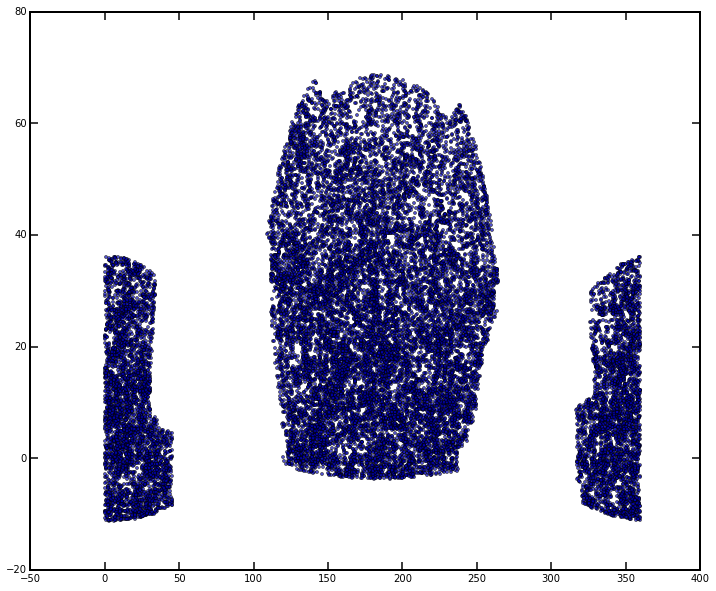

In [71]:
# RA, DEC distribution of thr random input 

plt.scatter(catData[ra], catData[dec], s=8, alpha=0.6)

In [72]:
# See how many fake objects that are inside the useful region 
%time inside = map(lambda x, y: acpRegs.contains(Point(x, y)), catData[ra], catData[dec])

CPU times: user 739 ms, sys: 6.71 ms, total: 746 ms
Wall time: 756 ms


In [73]:
# See how many fake objects that are affected by the NO_DATA regions 

# For this particular Tract, it is actually not very necessary, but I'll do it anyway to show you how it is done
%time masked = map(lambda x, y: rejRegs.contains(Point(x, y)), catData[ra], catData[dec])

CPU times: user 773 ms, sys: 7.52 ms, total: 781 ms
Wall time: 794 ms


In [74]:
# The fake objects that belong to INSIDE group, and that don't belong to the MASKED group are 
# the ones we want to inject to the images

useful = map(lambda x, y: x and (not y), inside, masked)

In [75]:
# Isolate these objects from the original input catalog 

objUse = catData[np.asarray(useful)]

In [76]:
# Basic statistics 

print "%d objects are in the Input Catalog" % len(catData)
print "%d objects are selected" % len(objUse)

26350 objects are in the Input Catalog
25 objects are selected


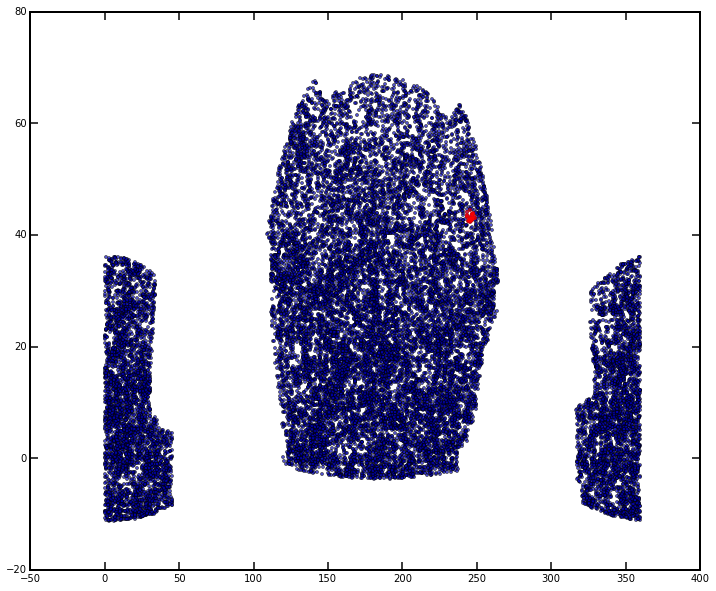

In [77]:
# Check the distribution again

plt.scatter(catData[ra], catData[dec], s=8, alpha=0.6)
plt.scatter(objUse[ra], objUse[dec], s=9, alpha=0.5, color='r')

In [78]:
# Write the output catalog 
#objUse.write(outCat + '.fits', format='fits')
objUse.write(outCat, format='fits')